In [1]:
import math as math
import numpy as np
import scipy as scipy
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
import matplotlib as mpl
import cmath
from numpy import linalg as la
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from scipy.optimize import curve_fit, minimize
from scipy import stats
from scipy.linalg import expm
from scipy.special import erf as erf
from math import sqrt, pi, exp, sin, cos
from cmath import exp as expc

In [2]:
%matplotlib inline

# Angular momentum operators

In [4]:
J1p=np.loadtxt('J1p8half.txt') #raising operator for the first atom, dimensionless
J1m=np.loadtxt('J1m8half.txt') #lowering operator for the first atom, dimensionless
J1z=np.loadtxt('J1z8half.txt') #z-component operator for the first atom, dimensionless
J2p=np.loadtxt('J2p8half.txt') #raising operator for the second atom, dimensionless
J2m=np.loadtxt('J2m8half.txt') #lowering operator for the second atom, dimensionless
J2z=np.loadtxt('J2z8half.txt') #z-component operator for the second atom, dimensionless
J3p=np.loadtxt('J3p8half.txt') #raising operator for the third atom, dimensionless
J3m=np.loadtxt('J3m8half.txt') #lowering operator for the third atom, dimensionless
J3z=np.loadtxt('J3z8half.txt') #z-component operator for the third atom, dimensionless

In [5]:
J1x=1/2.0*(J1p+J1m);
J2x=1/2.0*(J2p+J2m);
J3x=1/2.0*(J3p+J3m);
J1y=-1j/2.0*(J1p-J1m);
J2y=-1j/2.0*(J2p-J2m);
J3y=-1j/2.0*(J3p-J3m);
Jx=J1x+J2x+J3x;
Jy=J1y+J2y+J3y;
Jz=J1z+J2z+J3z;
J1=[J1x,J1y,J1z];
J2=[J2x,J2y,J2z];
J3=[J3x,J3y,J3z];

# Parameters

In [210]:
T=4.5;               #temperature in K
k=86.173324;         #Boltzmann constant in micro eV/K
beta=1/(k*T);
muB= 57.883818066;   #Bohr magneton in micro eV/T
g=1.25;               #Lande g-factor for Holmium, multiplied by 16 to adjust to the magnitude of the magnetic moment
# anisotropy unity vectors in the x-y plane:
e1 = [0.0, -1.0, 0.0];
e2 = [math.sqrt(3)/2.0, 0.5, 0.0];
e3 = [-math.sqrt(3)/2.0, 0.5, 0.0]; 

# Parts of the Hamiltonian

### Exchange coupling

In [211]:
def exch(Ex): #Ex is the exchange coupling constant in micro eV
    return Ex*(np.dot(J1x,J2x)+np.dot(J1y,J2y)+np.dot(J1z,J2z)
               +np.dot(J2x,J3x)+np.dot(J2y,J3y)+np.dot(J2z,J3z)
               +np.dot(J1x,J3x)+np.dot(J1y,J3y)+np.dot(J1z,J3z));
                #result in micro eV

### Anisotropy

In [212]:
def anisotr(K): #K is the anisotropy constant in micro eV
    return -K*(np.dot(np.tensordot(e1,J1,axes=([0],[0])),np.tensordot(e1,J1,axes=([0],[0])))
               +np.dot(np.tensordot(e2,J2,axes=([0],[0])),np.tensordot(e2,J2,axes=([0],[0])))
               +np.dot(np.tensordot(e3,J3,axes=([0],[0])),np.tensordot(e3,J3,axes=([0],[0]))));
                #result in micro eV

### Magnetic field

In [213]:
def field (B,phi,theta): #B is the magnitude of the magnetic field in T, phi the angle with x-axis in rad, theta the angle with z-axis in rad
    return muB*g*(B*math.sin(theta)*math.cos(phi)*Jx + B*math.sin(theta)*math.sin(phi)*Jy + B*math.cos(theta)*Jz)
    #result in micro eV

### Exchange coupling to substrate

In [214]:
def substr(a,M): #a=[a1,a2,a3] contains the different coupling strengths to substrate, M=[M1,M2,M3] is substrate magnetization
    a[0]*np.tensordot(M,J1,axes=([0],[0])) + a[1]*np.tensordot(M,J2,axes=([0],[0])) + a[2]*np.tensordot(M,J3,axes=([0],[0]))

# Hamiltonian

In [215]:
def H (B,phi,theta,Ex,K):
    return exch(Ex) + anisotr(K) + field(B,phi,theta) #for now we neglect coupling to substrate
    #result in micro eV

# Partition function and Magnetization

In [216]:
def Z (eigenvalues):
    return np.sum(np.exp(-beta*eigenvalues))

def Expectation (eigenvalues,eigenvectors,phi,theta):
    JB=math.sin(theta)*math.cos(phi)*Jx + math.sin(theta)*math.sin(phi)*Jy + math.cos(theta)*Jz
    Exp=np.dot(np.exp(-beta*eigenvalues)/Z(eigenvalues),np.diagonal(np.dot(np.conjugate(eigenvectors.T),np.dot(JB,eigenvectors))))
    return Exp
 
def Magnetization (B,phi,theta,Ex,K,scaling):
    eigenvals, eigenvecsT = la.eigh(H(B,phi,theta,Ex,K))
    return -scaling*muB*g*np.real(Expectation(eigenvals,eigenvecsT,phi,theta))
    #result is the expectation value of the total magnetic moment of the 3 atoms,
    #projected on the direction of the B-field, in the units of micro eV per Tesla

#def Magnetization (B,phi,theta,Ex,K):
 #   return Magnetization_nonnorm(B,phi,theta,Ex,K)/Magnetization_nonnorm(4.5,phi,theta,Ex,K)
    #result is the expectation value of the total magnetic moment of the 3 atoms,
    #normalized against the B-field value of 4.5 Tesla

MagnVectorized = np.vectorize(Magnetization)

# Input cell:

In [227]:
# theta is the angle between the z-axis and the magnetic field
# phi is the angle between the x-axis and the magnetic field

#thetaAver=70.0*pi/180.0;    #average value of theta (i.e., the intended angle of the B-field w.r.t. the surface normal)

xdata1=np.loadtxt('MHoCu20_xdata_complex.txt',dtype='cfloat') #measurement data for B-field values, T
ydata1=np.loadtxt('MHoCu20_ydata.txt') #measurement data for the magnetic momentum projection
                                                                            #on the B-field direction, micro eV per Tesla
xdata2=np.loadtxt('MHoCu90_xdata_complex.txt',dtype='cfloat') #measurement data for B-field values, T
ydata2=np.loadtxt('MHoCu90_ydata.txt') #measurement data for the magnetic momentum projection
                                                                            #on the B-field direction, micro eV per Tesla
ydata1=ydata1/ydata1[0];   #normalizing against the data point for B-field value of 4.5 T
ydata2=ydata2/ydata2[5];

xdata=np.concatenate((xdata1,xdata2))
ydata=np.concatenate((ydata1,ydata2))

Exinit=-500.0;          #initial value of Ex for fitting, in micro eV
Kinit=1000.0;           #initial value of K for fitting, in micro eV
sigmaInit=15.0*pi/180.0; #initial value of tilting angle variation for fitting, in rad
scalingInit=0.01;
x0=[Exinit,Kinit,sigmaInit,sigmaInit];
uncertainties=[0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03];

# Averaging over phi and theta

In [228]:
deltaphi=pi/6.0;   #half-period of magnetization oscillations in phi

def ThetaAver(BandTheta,phi,Ex,K,sigma,scaling):  #performs the average over theta when the average value of theta is thetaAvg, and standard deviation - sigma
    B=np.real(BandTheta)                  #BandTheta contains B as the real part and thetaAvg as the imaginary part -- it's a trick to circumvent a problem with np.vectorize
    thetaAvg=np.imag(BandTheta)
    lower=np.real(Magnetization(B,phi,0.0,Ex,K,scaling)) #lowest value of Magnetization as a function of theta (i.e., when theta=0)
    upper=np.real(Magnetization(B,phi,pi/2.0,Ex,K,scaling))
    diff=upper-lower  #amplitude in oscillations of Magnetization as a function of theta
    return    np.real((2*(diff + 2*lower)*(erf(thetaAvg/(sqrt(2)*sigma)) - 
               erf((thetaAvg - 2*pi)/(sqrt(2)*sigma))) + 
               diff*expc(-2j*thetaAvg - 
               2*sigma*sigma)*(-erf((thetaAvg - 2j*sigma*sigma)/(sqrt(2)*sigma)) + 
               expc(4j*thetaAvg)*(-erf((thetaAvg + 2j*sigma*sigma)/(sqrt(2)*sigma)) + 
               erf((thetaAvg - 2*pi + 2j*sigma*sigma)/(sqrt(2)*sigma))) + 
               erf((thetaAvg - 2*(pi + 1j*sigma*sigma))/(sqrt(2)*sigma))))/8)

def MagnAveraged(BandTheta,Ex,K,sigma,scaling): #averages over the angle phi, i.e., gives the final average over angles
    return (ThetaAver(BandTheta,0,Ex,K,sigma,scaling)+ThetaAver(BandTheta,deltaphi,Ex,K,sigma,scaling))/2.0

MagnAverVectorized = np.vectorize(MagnAveraged) #makes MagnPhiAver accept arrays as arguments (needed for fitting,
                                                                                             #perhaps also easier to plot with)

In [174]:
%%time
MagnAverVectorized(xdata2,Exinit,Kinit,sigmaInit)

CPU times: user 8min 31s, sys: 1.95 s, total: 8min 33s
Wall time: 8min 32s


array([ 0.02755105,  0.06734726,  0.12792724,  0.23751405,  0.34308406,
        0.5       ,  0.65557507])

In [176]:
%%time
MagnAveraged(4.5+1j*70.0*pi/180.0,Exinit,Kinit,sigmaInit)

0.99999846937326353

In [177]:
%%time
MagnAveraged(4.5+1j*0.0,Exinit,Kinit,sigmaInit)

CPU times: user 38.5 s, sys: 196 ms, total: 38.7 s
Wall time: 38.7 s


0.5

# Fitting

In [229]:
%%time
params, covariance = curve_fit(MagnAverVectorized, xdata, ydata, sigma=uncertainties, p0=(Exinit,Kinit,sigmaInit,scalingInit))
#returns the optimal parameter values and covariance,
#see http://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html#scipy.optimize.curve_fit for more details

-c:6: RuntimeWarning: overflow encountered in exp
-c:2: RuntimeWarning: overflow encountered in exp
-c:6: RuntimeWarning: invalid value encountered in divide


KeyboardInterrupt: 

In [67]:
params #first is the fitted value for Ex, second -- for K, third -- for sigma

array([ -2.32859529e+03,   4.53826384e+03,   3.16531866e-01])

In [22]:
covariance #covariance matrix for Ex, K, sigma, scaling

array([[  7.34948954e+09,  -1.36322981e+10,  -1.70521284e+04],
       [ -1.36322981e+10,   2.52883061e+10,   3.15912287e+04],
       [ -1.70521284e+04,   3.15912287e+04,   4.10073183e-02]])

In [21]:
stdev=np.sqrt(np.diag(covariance)) #standard deviations for Ex, K, sigma
stdev

array([  8.57291639e+04,   1.59022973e+05,   2.02502638e-01])

In [20]:
np.savetxt('parameters_8half_2angles.txt',params)
np.savetxt('st_deviations_8half_2angles.txt',stdev)

# Results

### Experimental data together with the fit

CPU times: user 1.49 s, sys: 0 ns, total: 1.49 s
Wall time: 1.49 s


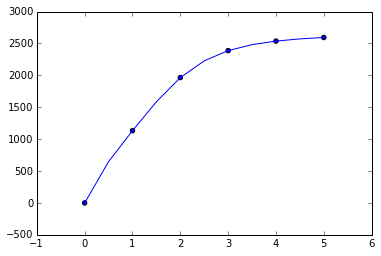

In [19]:
%%time
nB=11; #number of B-field value points
B0=0;  #lowest B-field value
B1=5;  #highest B-field value
Binput=np.linspace(B0,B1,nB);
plt.plot(Binput,MagnAverVectorized(Binput,params[0],params[1],params[2],params[3])) #plotting the magnetization with the fitted parameters
plt.scatter(xdata,ydata)                                           #plotting the data from experiment

CPU times: user 9min 16s, sys: 3.12 s, total: 9min 20s
Wall time: 9min 19s


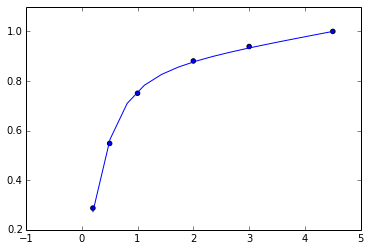

In [43]:
%%time
nB=15; #number of B-field value points
B0=0.2;  #lowest B-field value
B1=4.5;  #highest B-field value
Binput=np.linspace(B0,B1,nB);
plt.scatter(xdata,ydata)
plt.plot(Binput,MagnAverVectorized(Binput,Exinit,Kinit,sigmaInit))

CPU times: user 9min 59s, sys: 3.12 s, total: 10min 2s
Wall time: 10min 2s


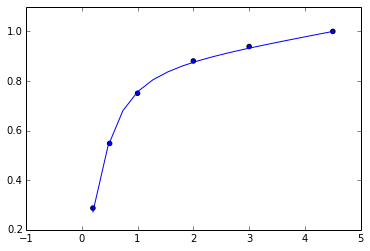

In [46]:
%%time
nB=17; #number of B-field value points
B0=0.2;  #lowest B-field value
B1=4.5;  #highest B-field value
Binput=np.linspace(B0,B1,nB);
plt.scatter(xdata,ydata)
plt.plot(Binput,MagnAverVectorized(Binput,params[0],params[1],params[2]))

In [51]:
params

array([ -2.32859529e+03,   4.53826384e+03,   3.16531866e-01])

CPU times: user 10min 36s, sys: 3.4 s, total: 10min 39s
Wall time: 10min 39s


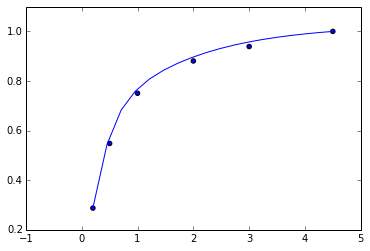

In [47]:
%%time
nB=18; #number of B-field value points
B0=0.2;  #lowest B-field value
B1=4.5;  #highest B-field value
Binput=np.linspace(B0,B1,nB);
plt.scatter(xdata,ydata)
plt.plot(Binput,MagnAverVectorized(Binput,-2000.0,100.0,0.3))

In [50]:
0.3*180/pi

17.188733853924695

CPU times: user 11min 36s, sys: 3.77 s, total: 11min 40s
Wall time: 11min 39s


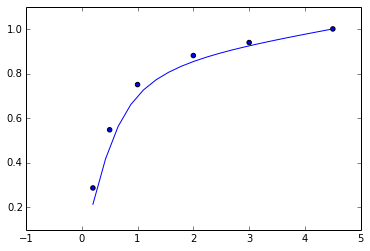

In [48]:
%%time
nB=20; #number of B-field value points
B0=0.2;  #lowest B-field value
B1=4.5;  #highest B-field value
Binput=np.linspace(B0,B1,nB);
plt.scatter(xdata,ydata)
plt.plot(Binput,MagnAverVectorized(Binput,-100.0,2000.0,0.3))

## g = 1.25

CPU times: user 1min 56s, sys: 16 ms, total: 1min 56s
Wall time: 1min 56s


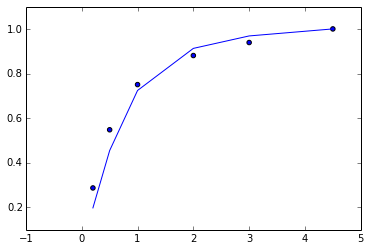

In [65]:
%%time
plt.scatter(xdata,ydata)
plt.plot(xdata,(MagnVectorized(xdata,0.0,thetaAver,-500.0,1000.0)+MagnVectorized(xdata,deltaphi,thetaAver,-500.0,1000.0))/2)

CPU times: user 3min 52s, sys: 4 ms, total: 3min 52s
Wall time: 3min 52s


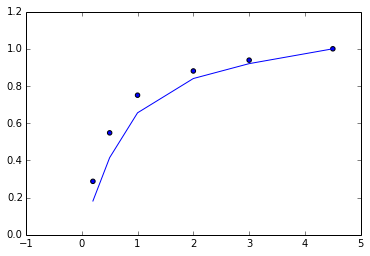

In [66]:
%%time
plt.scatter(xdata,ydata)
plt.plot(xdata,MagnAverVectorized(xdata,params[0],params[1],params[2]))

CPU times: user 476 ms, sys: 4 ms, total: 480 ms
Wall time: 477 ms


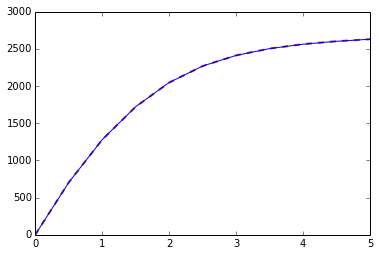

In [88]:
%%time
nB=11; #number of B-field value points
B0=0;  #lowest B-field value
B1=5;  #highest B-field value
Binput=np.linspace(B0,B1,nB);
MagnOutput=np.zeros(nB)
for i in range(0,nB):
        MagnOutput[i]=np.real(Magnetization(Binput[i],0,thetaAver,-100.0,1000.0))
plt.plot(Binput,MagnOutput,color='#a52a2a',linestyle='--',linewidth=2)
plt.plot(Binput,MagnAverVectorized(Binput,-100.0,1000.0))

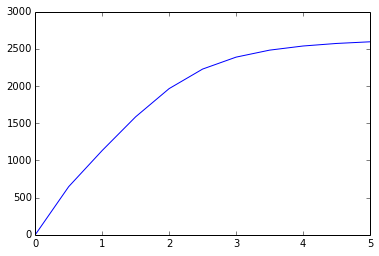

In [19]:
plt.plot(Binput,MagnAverVectorized(Binput,-100.0,1000.0,10.0*pi/180.0))

In [20]:
np.savetxt('ydata.txt',MagnAverVectorized(Binput,-100.0,1000.0,10.0*pi/180.0))

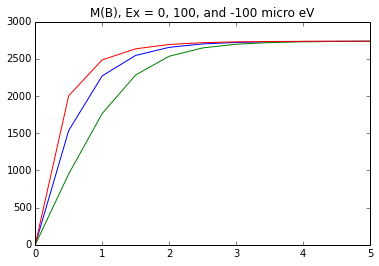

In [16]:
nB=11; #number of B-field value points
B0=0;  #lowest B-field value
B1=5;  #highest B-field value
Binput=np.linspace(B0,B1,nB);
MagnOutput=np.zeros(nB)
for i in range(0,nB):
        MagnOutput[i]=np.real(Magnetization(Binput[i],0,0,0,0))
plt.plot(Binput,MagnOutput)
for i in range(0,nB):
        MagnOutput[i]=np.real(Magnetization(Binput[i],0,0,100,0))
plt.plot(Binput,MagnOutput)
for i in range(0,nB):
        MagnOutput[i]=np.real(Magnetization(Binput[i],0,0,-100,0))
plt.plot(Binput,MagnOutput)
plt.title('M(B), Ex = 0, 100, and -100 micro eV')
plt.show()

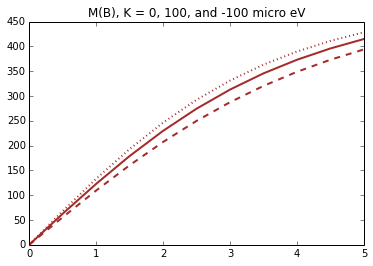

In [22]:
nB=11; #number of B-field value points
B0=0;  #lowest B-field value
B1=5;  #highest B-field value
Binput=np.linspace(B0,B1,nB);
MagnOutput=np.zeros(nB)
for i in range(0,nB):
        MagnOutput[i]=np.real(Magnetization(Binput[i],0,0,0,0))
plt.plot(Binput,MagnOutput,color='#a52a2a',linestyle='-',linewidth=2)
for i in range(0,nB):
        MagnOutput[i]=np.real(Magnetization(Binput[i],0,0,0,100))
plt.plot(Binput,MagnOutput,color='#a52a2a',linestyle='--',linewidth=2)
for i in range(0,nB):
        MagnOutput[i]=np.real(Magnetization(Binput[i],0,0,0,-100))
plt.plot(Binput,MagnOutput,color='#a52a2a',linestyle=':',linewidth=2)
plt.title('M(B), K = 0, 100, and -100 micro eV')
plt.show()

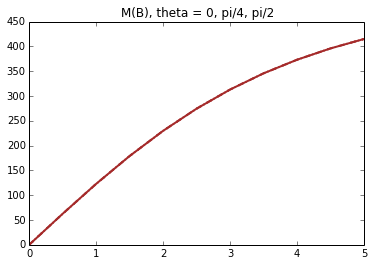

In [23]:
nB=11; #number of B-field value points
B0=0;  #lowest B-field value
B1=5;  #highest B-field value
Binput=np.linspace(B0,B1,nB);
MagnOutput=np.zeros(nB)
for i in range(0,nB):
        MagnOutput[i]=np.real(Magnetization(Binput[i],0.0,0.0,0,0.0))
plt.plot(Binput,MagnOutput,color='#a52a2a',linestyle='-',linewidth=2)
for i in range(0,nB):
        MagnOutput[i]=np.real(Magnetization(Binput[i],0.0,np.pi/4,0.0,0.0))
plt.plot(Binput,MagnOutput,color='#a52a2a',linestyle='--',linewidth=2)
for i in range(0,nB):
        MagnOutput[i]=np.real(Magnetization(Binput[i],0.0,np.pi/2,0.0,0.0))
plt.plot(Binput,MagnOutput,color='#a52a2a',linestyle=':',linewidth=2)
plt.title('M(B), theta = 0, pi/4, pi/2')
plt.show()

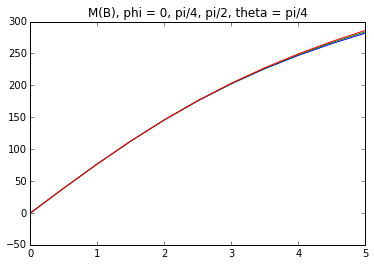

In [24]:
nB=11; #number of B-field value points
B0=0;  #lowest B-field value
B1=5;  #highest B-field value
Binput=np.linspace(B0,B1,nB);
MagnOutput=np.zeros(nB)
for i in range(0,nB):
        MagnOutput[i]=np.real(Magnetization(Binput[i],0,np.pi/4,0,1000))
plt.plot(Binput,MagnOutput)
for i in range(0,nB):
        MagnOutput[i]=np.real(Magnetization(Binput[i],np.pi/4,np.pi/4,0,1000))
plt.plot(Binput,MagnOutput)
for i in range(0,nB):
        MagnOutput[i]=np.real(Magnetization(Binput[i],np.pi/2,np.pi/4,0,1000))
plt.plot(Binput,MagnOutput)
plt.title('M(B), phi = 0, pi/4, pi/2, theta = pi/4')
plt.show()

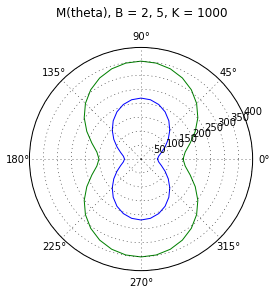

In [27]:
nB=41; #number of B-field value points
thetaInput = np.linspace(0,2*np.pi,nB)
MagnOutput=np.zeros(nB)
for i in range(0,nB): MagnOutput[i]=np.real(Magnetization(2.0,0,thetaInput[i],0,1000))
plt.subplot(polar=True)
plt.plot(thetaInput,MagnOutput)
for i in range(0,nB): MagnOutput[i]=np.real(Magnetization(5.0,0,thetaInput[i],0,1000))
plt.subplot(polar=True)
plt.plot(thetaInput,MagnOutput) 
plt.title("M(theta), B = 2, 5, K = 1000\n")
plt.show()

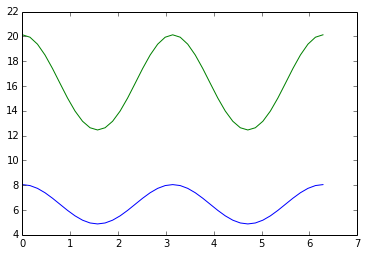

In [79]:
nB=41; #number of B-field value points
thetaInput = np.linspace(0,2*np.pi,nB)
MagnOutput=np.zeros(nB)
for i in range(0,nB): MagnOutput[i]=np.real(Magnetization(2.0,0,thetaInput[i],1000,5000))
#plt.subplot(polar=True)
plt.plot(thetaInput,MagnOutput)
for i in range(0,nB): MagnOutput[i]=np.real(Magnetization(5.0,0,thetaInput[i],1000,5000))
#plt.subplot(polar=True)
plt.plot(thetaInput,MagnOutput)

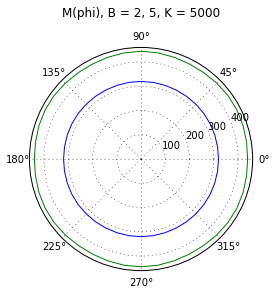

In [78]:
nB=41; #number of B-field value points
phiInput = np.linspace(0,2*np.pi,nB)
MagnOutput=np.zeros(nB)
for i in range(0,nB): MagnOutput[i]=np.real(Magnetization(2,phiInput[i],np.pi/2,-100,500))
plt.subplot(polar=True)
plt.plot(thetaInput,MagnOutput) #shouldn't this be phiInput?
for i in range(0,nB): MagnOutput[i]=np.real(Magnetization(5,phiInput[i],np.pi/2,-100,500))
plt.subplot(polar=True)
plt.plot(thetaInput,MagnOutput) 
plt.title("M(phi), B = 2, 5, K = 5000\n")
plt.show()

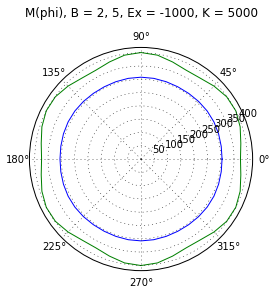

In [66]:
nB=41; #number of B-field value points
phiInput = np.linspace(0,2*np.pi,nB)
MagnOutput=np.zeros(nB)
for i in range(0,nB): MagnOutput[i]=np.real(Magnetization(2,phiInput[i],np.pi/2,-1000,5000))
plt.subplot(polar=True)
plt.plot(thetaInput,MagnOutput)
for i in range(0,nB): MagnOutput[i]=np.real(Magnetization(5,phiInput[i],np.pi/2,-1000,5000))
plt.subplot(polar=True)
plt.plot(thetaInput,MagnOutput) 
plt.title("M(phi), B = 2, 5, Ex = -1000, K = 5000\n")
plt.show()

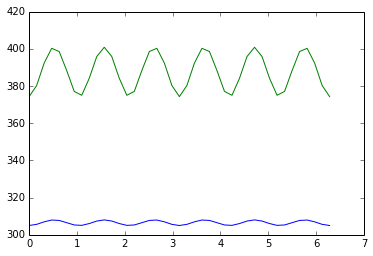

In [37]:
nB=41; #number of B-field value points
phiInput = np.linspace(0,2*np.pi,nB)
MagnOutput=np.zeros(nB)
for i in range(0,nB): MagnOutput[i]=np.real(Magnetization(2,phiInput[i],np.pi/2,-1000,5000))
#plt.subplot(polar=True)
plt.plot(thetaInput,MagnOutput)
for i in range(0,nB): MagnOutput[i]=np.real(Magnetization(5,phiInput[i],np.pi/2,-1000,5000))
#plt.subplot(polar=True)
plt.plot(thetaInput,MagnOutput)